## 1. 사용할 패키지 불러오기

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd '/content/drive/MyDrive/kmong/car_number'

/content/drive/MyDrive/kmong/car_number


In [14]:
import sys
sys.path.append('/content/gdrive/MyDrive/kmong/car_number/data_gen')

In [15]:
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import json
from data_gen.data_gen import ClassDatasetGenerator
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 2. 데이터 불러오기

### (1) Cropped Image 경로 불러오기

In [16]:
train_img_path = "/content/drive/MyDrive/kmong/car_number/cropped_dataset/train"
test_img_path = "/content/drive/MyDrive/kmong/car_number/cropped_dataset/test"

### (2) Train 및 Test 데이터셋 생성

In [17]:
def prepare_data(image_path):
    """
    Extract file names with target class
    Parameters
    ----------
    train_path : str
        train data path (csv or folders with class name)
    remove_filename_list : list
        file names which should be removed.
    Returns
    --------
    file names, unique label names, target class
    """

    files = []
    for ty in os.listdir(image_path):
        filelist = os.listdir(os.path.join(image_path, ty))
        for i, file in enumerate(filelist):
            files.append(os.path.join(image_path, ty, file))
        labels = [file.split('/')[-2] for file in files]

    uni_label = np.unique(labels)
    print("There are {} classes: {}".format(len(uni_label), uni_label))
    y = np.array([np.eye(len(uni_label))[np.where(uni_label==label)].reshape(-1) for label in labels])

    return files, uni_label, y

In [18]:
train_img_list, uni_label, train_target_list = prepare_data(image_path = train_img_path)
test_img_list, uni_label, test_target_list = prepare_data(image_path = test_img_path)

There are 9 classes: ['1996_n' '2004_n' '2006_eu' '2006_n' '2006_us' '2019_n' '2019_r' 'bike'
 'echo']
There are 9 classes: ['1996_n' '2004_n' '2006_eu' '2006_n' '2006_us' '2019_n' '2019_r' 'bike'
 'echo']


## 3. 모델링

### (1) Dataloader 생성

In [19]:
train_dataset = ClassDatasetGenerator(train_img_list, train_target_list, batch_size = 16, phase = 'train')
train_dataloader = train_dataset.dataloader()
test_dataset = ClassDatasetGenerator(test_img_list, test_target_list, batch_size = 1, phase = 'test')
test_dataloader = test_dataset.dataloader() 

### (2) Model 생성

In [20]:
model_name = 'resnet18'


In [21]:
# build model
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, len(uni_label))

### (3) 학습 파라미터 지정

In [22]:
epoch = 100
learning_rate = 0.001
weight_decay = 0.0001
result_dir = './result/'
os.makedirs(result_dir, exist_ok = True)

### (4) Loss, Optimizer 생성

In [23]:
# get loss function from LossFactory
loss_fn = CrossEntropyLoss()

# get optimizer from OptimizerFactory
optimizer = Adam(params = vision_model.parameters(),
                lr=learning_rate,
                weight_decay = weight_decay)

### (5) 학습

In [24]:
print("{} start training!".format(model_name))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vision_model.to(device)
min_valid_acc = 0


for e in range(epoch):
    train_loss = 0.0
    correct = 0
    total = 0
    vision_model.train()     # Optional when not using Model Specific layer
    for data in train_dataloader['train']:
        if torch.cuda.is_available():
            images, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        optimizer.zero_grad()
        target = vision_model(images)
        loss = loss_fn(target,torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(target, 1)
        correct += (predicted == torch.argmax(labels, dim=1)).float().sum()
        total += labels.size(0)
            
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    vision_model.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader['test']:
        if torch.cuda.is_available():
            data, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        target = vision_model(data)
        loss = loss_fn(target,torch.argmax(labels, dim=1))
        valid_loss = loss.item() * data.size(0)
        _, predicted = torch.max(target, 1)
        correct += (predicted == torch.argmax(labels, dim=1)).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Test Loss: {valid_loss / len(test_dataloader)} \t Test Acc: {valid_acc}')
    if min_valid_acc < valid_acc:
        print(f'Validation Loss Increased({min_valid_acc:.6f}--->{valid_acc:.6f}) \t Saving The Model')
        min_valid_acc = valid_acc
        # Saving State Dict
        torch.save(vision_model.state_dict(), result_dir + 'Classification_Best_model.pth')

resnet18 start training!
Epoch 1 	 Training Loss: 41.53722104430199 	 Training Acc: 0.7938247323036194 		 Test Loss: 2.299095392227173 	 Test Acc: 0.7272727489471436
Validation Loss Increased(0.000000--->0.727273) 	 Saving The Model
Epoch 2 	 Training Loss: 17.136011784896255 	 Training Acc: 0.9153386950492859 		 Test Loss: 0.3903273046016693 	 Test Acc: 0.8831169009208679
Validation Loss Increased(0.727273--->0.883117) 	 Saving The Model
Epoch 3 	 Training Loss: 17.017982760444283 	 Training Acc: 0.9223107695579529 		 Test Loss: 2.3871986865997314 	 Test Acc: 0.8181818127632141
Epoch 4 	 Training Loss: 10.504266665317118 	 Training Acc: 0.9571713209152222 		 Test Loss: 8.559981346130371 	 Test Acc: 0.948051929473877
Validation Loss Increased(0.883117--->0.948052) 	 Saving The Model
Epoch 5 	 Training Loss: 6.234483084408566 	 Training Acc: 0.967131495475769 		 Test Loss: 5.574399471282959 	 Test Acc: 0.9350649118423462
Epoch 6 	 Training Loss: 9.103449672460556 	 Training Acc: 0.95219

### (6) Load Best Model

In [ ]:
vision_model.load_state_dict(torch.load('result/Classification_Best_model.pth'))

<All keys matched successfully>

### (7) 성능 평가

In [ ]:
print('Test Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.argmax(dim=1, keepdim = False)
        pred = list(pred.cpu().numpy())
        predictions = predictions + pred

Test Prediction


Text(0.5, 1.0, 'Confusion_matrix')

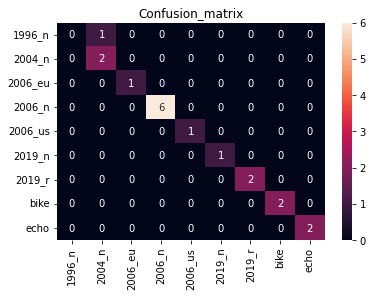

In [ ]:
ground_truth = np.argmax(test_target_list, axis=-1)
distribution = confusion_matrix(ground_truth, predictions)
plt.figure()
distribution = pd.DataFrame(distribution, index=uni_label, columns=uni_label)
ax = sns.heatmap(distribution, annot=True)
plt.title('Confusion_matrix')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print("Test Accuracy: {}".format(accuracy_score(ground_truth, predictions)))

Test Accuracy: 0.9444444444444444


In [ ]:
print(predictions)

[3, 3, 3, 3, 3, 3, 1, 1, 8, 8, 5, 6, 6, 2, 4, 7, 7, 1]
